In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('..\\..')

In [2]:
from experiments.index_investigation.investigator import IndexInvestigator, IndexInvestigationResultDTO
from mirage.index.MirageIndex import MirageIndex
from faiss import IndexFlatL2


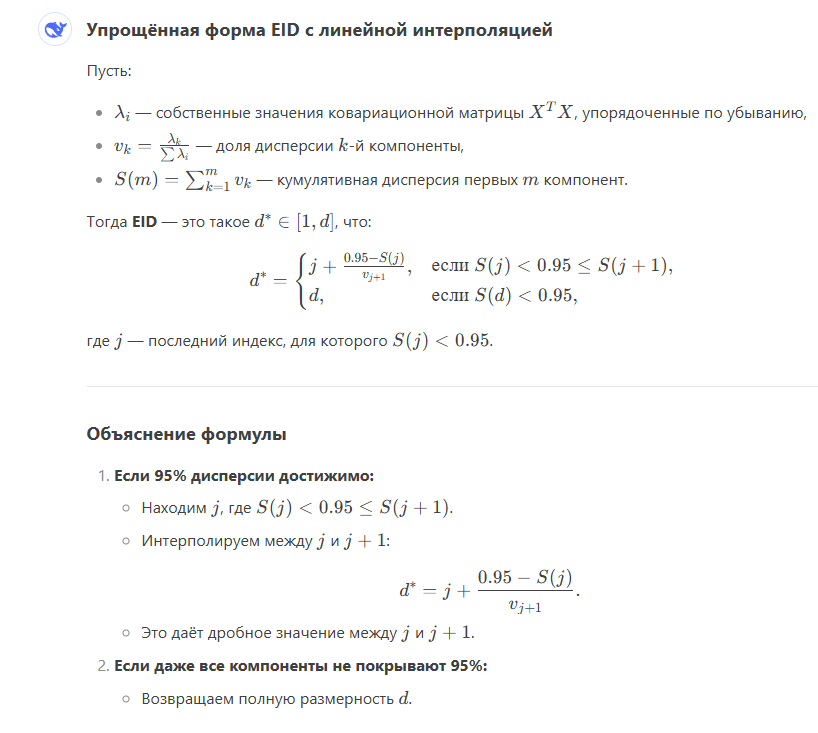


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.manifold import TSNE

def plot_vectors_with_labels(vectors, labels, method='tsne', random_state=42):
    """
    Визуализирует векторы с метками, используя снижение размерности и цветовую палитру magma.
    
    Параметры:
    vectors : numpy.ndarray или подобный массив
        Матрица векторов для визуализации (n_samples, n_features)
    labels : numpy.ndarray или подобный массив
        Массив меток для каждого вектора (n_samples,)
    method : str, optional ('tsne' или 'pca')
        Метод снижения размерности (по умолчанию 'tsne')
    random_state : int, optional
        Seed для воспроизводимости (по умолчанию 42)
    """
    # Проверка входных данных
    if len(vectors) != len(labels):
        raise ValueError("Количество векторов и меток должно совпадать")
    
    # Стандартизация данных
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(vectors)
    
    # Снижение размерности
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state, perplexity=30, n_iter=1000)
        reduced_vectors = reducer.fit_transform(vectors_scaled)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=random_state)
        reduced_vectors = reducer.fit_transform(vectors_scaled)
    else:
        raise ValueError("Метод должен быть 'tsne' или 'pca'")
    
    # Создание DataFrame для удобства построения
    import pandas as pd
    df = pd.DataFrame({
        'x': reduced_vectors[:, 0],
        'y': reduced_vectors[:, 1],
        'label': labels
    })
    
    # Настройка стиля
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 8))
    
    # Построение графика
    scatter = sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue='label',
        palette='magma',
        s=70,
        alpha=0.8,
        edgecolor='w',
        linewidth=0.5
    )
    
    # Добавление заголовка и легенды
    method_name = 't-SNE' if method == 'tsne' else 'PCA'
    plt.title(f'Визуализация меток с помощью {method_name}', pad=20)
    plt.xlabel('Компонента 1')
    plt.ylabel('Компонента 2')
    
    # Улучшение легенды
    legend = scatter.legend()
    legend.set_title('Метки')
    
    # Улучшение внешнего вида
    sns.despine()
    plt.tight_layout()
    plt.show()

In [4]:
# plot_vectors_with_labels(
#     vectors=investigator.vector_matrix, 
#     labels=investigator.document_labels
# )

In [5]:
import pandas as pd
from tqdm import tqdm

path = 'E:/indexes1'
files = [fr'{path}/{i}' for i in os.listdir(path)]
results = []
for file in tqdm(files):
    ...
    # mirage_index = MirageIndex.load(file)
    # investigator = IndexInvestigator(mirage_index)
    # result: IndexInvestigationResultDTO = investigator.process()
    # result.file = file
    # results.append(result.model_dump())

resdf = pd.DataFrame(results)

100%|██████████| 240/240 [00:00<?, ?it/s]


In [6]:
resdf

""


In [7]:
# resdf.to_pickle('E:/indres/bench1.pkl')

In [30]:
resdf = pd.read_pickle('E:/indres/bench2.pkl')

In [31]:
counter = 0
cache = {}
from tqdm import tqdm
tqdm.pandas()

def update_eid(filename: str):
    # global counter
    # counter += 1
    # print(counter, end='\r')
    if 'l2' in filename:
        return cache[filename.replace('l2', 'ip')]
    mirage_index = MirageIndex.load(filename)
    investigator = IndexInvestigator(mirage_index)
    result: IndexInvestigationResultDTO = investigator.calculate_EID()
    cache[filename] = (result, investigator.vector_matrix.shape[1])
    return result, investigator.vector_matrix.shape[1]

result = resdf['file'].progress_apply(update_eid) 

100%|██████████| 240/240 [07:36<00:00,  1.90s/it]


In [32]:
values1 = [x[0] for x in result]
values2 = [x[1] for x in result]

# Add these as new columns to your DataFrame
resdf['EID'] = values1
resdf['dim'] = values2

In [33]:
resdf['redundancy'] = 1 - (resdf['EID'] / resdf['dim'])


In [34]:
resdf

,file,vector_variance,silhouette_score_euclidian,silhouette_score_cosine,EID,redundancy,LOFs,mean_LOF,std_LOF,dim
0,E:/indexes2/0_W_128_0.1_intfloat_ip.mirage_index,0.191654,0.076762,0.136420,253.038425,0.341046,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.999080,0.042894,384
1,E:/indexes2/0_W_128_0.1_intfloat_l2.mirage_index,0.191654,0.076762,0.136420,253.038425,0.341046,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.999080,0.042894,384
2,E:/indexes2/100_S_16_0.25_intfloat_ip.mirage_i...,0.158008,0.144099,0.254549,182.138501,0.525681,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,0.000000,384
3,E:/indexes2/100_S_16_0.25_intfloat_l2.mirage_i...,0.158008,0.144099,0.254549,182.138501,0.525681,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,0.000000,384
4,E:/indexes2/101_S_16_0.25_BAAI_ip.mirage_index,0.432483,0.154361,0.270947,200.404309,0.804293,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,0.000000,1024
...,...,...,...,...,...,...,...,...,...,...
235,E:/indexes2/98_S_16_0.1_thenlper_l2.mirage_index,0.169761,0.141331,0.246508,177.032864,0.769488,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,0.000000,768
236,E:/indexes2/99_S_16_0.1_DeepPavlov_ip.mirage_i...,47.049575,-0.013685,-0.033610,68.500858,0.910806,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0,...",0.960199,0.279317,768
237,E:/indexes2/99_S_16_0.1_DeepPavlov_l2.mirage_i...,47.049575,-0.013685,-0.033610,68.500858,0.910806,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0,...",0.960199,0.279317,768
238,E:/indexes2/9_W_128_0.5_BAAI_ip.mirage_index,0.502830,0.068817,0.122479,315.894282,0.691509,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.999490,0.031940,1024


In [35]:
resdf.to_pickle('E:/indres/bench2_1.pkl')